In [2]:

#%matplotlib tk
%matplotlib notebook
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os 
import matplotlib.animation as animation
import seaborn as sns
import numpy as np
#%matplotlib inline



In [3]:
data_root = 'data/'
print(os.listdir(data_root))

['CPI_Data_DashboardExtract_Price.csv', 'CPI_Data_DashboardExtract.csv', 'location_lookup.csv', 'ghg-emissions.csv', 'CPI_Data_DashboardExtract_Revenue.csv', 'ghg-emissions_percentage.csv', 'history_data_20001231-20210227.csv', 'CPI_Data_DashboardExtract_Emission.csv', 'CPI_Data_DashboardExtract_Gen_Info.csv']


In [4]:
carbon_data_path = 'data/'+ 'CPI_Data_DashboardExtract.csv'
temp_df= pd.read_csv(carbon_data_path,skiprows=2)
temp_df = temp_df[temp_df['Year of implementation']!= 'TBC']
temp_df['Year of implementation'] = temp_df['Year of implementation'].astype('int')
temp_df

,Name of the initiative,Type,Status,Type of juridiction covered,Jurisdiction covered,World Bank region,Year of implementation,Year of abolishment,GHG emissions covered [MtCO2e],Proportion of global GHG emissions covered,"Government income, previous year",Value [billion US$],Initiatives with overlapping GHG emissions covered,Covered GHG emissions overlapping with other initiatives [MtCO2e]
0,Alberta TIER,ETS,Implemented,Subnational,Alberta,North America,2007,0,131.904000,0.002435,0.367607,2.783372,NaN,NaN
1,Alberta carbon tax,Carbon tax,Implemented,Subnational,Alberta,North America,2017,2020,0.000000,0.000000,NaN,0.942534,NaN,NaN
2,Argentina carbon tax,Carbon tax,Implemented,National,Argentina,Latin America and the Caribbean,2018,0,88.124800,0.001627,0.179263,0.180258,NaN,NaN
3,Australia ERF Safeguard Mechanism,ETS,Implemented,National,Australia,East Asia & Pacific,2016,0,344.208000,0.006354,NaN,3.509703,NaN,NaN
5,BC GGIRCA,ETS,Implemented,Subnational,British Columbia,North America,2016,0,0.000000,0.000000,NaN,0.000000,BC carbon tax,0.000000
6,BC carbon tax,Carbon tax,Implemented,Subnational,British Columbia,North America,2008,0,41.650000,0.000769,1.145108,1.374763,BC GGIRCA,0.000000
7,Baja Calfornia carbon tax,Carbon tax,Implemented,Subnational,Baja California,Latin America and the Caribbean,2020,0,NaN,NaN,NaN,0.000000,NaN,NaN
8,Beijing pilot ETS,ETS,Implemented,Subnational,Beijing,East Asia & Pacific,2013,0,84.645000,0.001562,0.000000,0.610211,China national ETS,29.625750
10,California CaT,ETS,Implemented,Subnational,California,North America,2012,0,375.166200,0.006925,3.064750,5.113260,NaN,NaN
11,Canada federal OBPS,ETS,Implemented,National,Canada,North America,2019,0,70.948687,0.001310,NaN,0.000000,NaN,NaN


In [6]:
TaxData = temp_df[temp_df["Status"]=="Implemented"]
TaxData = TaxData[TaxData["Year of implementation"]>= 2002]
TaxData = TaxData[TaxData["Year of implementation"]<= 2017]
TaxData

,Name of the initiative,Type,Status,Type of juridiction covered,Jurisdiction covered,World Bank region,Year of implementation,Year of abolishment,GHG emissions covered [MtCO2e],Proportion of global GHG emissions covered,"Government income, previous year",Value [billion US$],Initiatives with overlapping GHG emissions covered,Covered GHG emissions overlapping with other initiatives [MtCO2e]
0,Alberta TIER,ETS,Implemented,Subnational,Alberta,North America,2007,0,131.904000,2.434763e-03,0.367607,2.783372,NaN,NaN
1,Alberta carbon tax,Carbon tax,Implemented,Subnational,Alberta,North America,2017,2020,0.000000,0.000000e+00,NaN,0.942534,NaN,NaN
3,Australia ERF Safeguard Mechanism,ETS,Implemented,National,Australia,East Asia & Pacific,2016,0,344.208000,6.353596e-03,NaN,3.509703,NaN,NaN
5,BC GGIRCA,ETS,Implemented,Subnational,British Columbia,North America,2016,0,0.000000,0.000000e+00,NaN,0.000000,BC carbon tax,0.000000
6,BC carbon tax,Carbon tax,Implemented,Subnational,British Columbia,North America,2008,0,41.650000,7.688000e-04,1.145108,1.374763,BC GGIRCA,0.000000
8,Beijing pilot ETS,ETS,Implemented,Subnational,Beijing,East Asia & Pacific,2013,0,84.645000,1.562428e-03,0.000000,0.610211,China national ETS,29.625750
10,California CaT,ETS,Implemented,Subnational,California,North America,2012,0,375.166200,6.925041e-03,3.064750,5.113260,NaN,NaN
15,Chile carbon tax,Carbon tax,Implemented,National,Chile,Latin America and the Caribbean,2017,0,57.610924,1.063417e-03,0.165500,0.165500,NaN,NaN
17,Chongqing pilot ETS,ETS,Implemented,Subnational,Chongqing,East Asia & Pacific,2014,0,121.550000,2.243642e-03,0.000000,0.530539,China national ETS,42.542500
19,Colombia carbon tax,Carbon tax,Implemented,National,Colombia,Latin America and the Caribbean,2017,0,45.665520,8.429210e-04,0.111245,0.116589,NaN,NaN


In [7]:
CanadaRegions = ["Alberta","British Columbia", "Quebec"]
ChinaRegions = ["Shanghai","Beijing"]
TaxData = TaxData[TaxData["Jurisdiction covered"].isin(ChinaRegions)]
TaxData

,Name of the initiative,Type,Status,Type of juridiction covered,Jurisdiction covered,World Bank region,Year of implementation,Year of abolishment,GHG emissions covered [MtCO2e],Proportion of global GHG emissions covered,"Government income, previous year",Value [billion US$],Initiatives with overlapping GHG emissions covered,Covered GHG emissions overlapping with other initiatives [MtCO2e]
8,Beijing pilot ETS,ETS,Implemented,Subnational,Beijing,East Asia & Pacific,2013,0,84.645,0.001562,0.000000,0.610211,China national ETS,29.62575
69,Shanghai pilot ETS,ETS,Implemented,Subnational,Shanghai,East Asia & Pacific,2013,0,169.689,0.003132,0.000495,0.800887,China national ETS,59.39115


In [8]:
policyYears = TaxData["Year of implementation"].unique()
print(policyYears)

[2013]


In [9]:
# carbon_emission_data_path = 'data/'+ 'CPI_Data_DashboardExtract_Emission.csv'
# temp_df= pd.read_csv(carbon_emission_data_path,skiprows=2)
# temp_df.head()
# need to fill out missing value w sthin

In [10]:
#temp data import 
temp_data_path = 'data/'+ 'history_data_20001231-20210227.csv'
temp_df= pd.read_csv(temp_data_path)
temp_df.head()


,location_id,date,maxTemp,minTemp,prcp
0,ST801,20010106,32.7,15.2,0.42
1,ST801,20010113,26.7,8.7,0.08
2,ST801,20010120,23.8,6.6,0.03
3,ST801,20010127,31.4,14.4,0.05
4,ST801,20010203,35.4,15.3,0.03


In [11]:

#location data 
location_path = data_root + 'location_lookup.csv'
loc_df = pd.read_csv(location_path)
loc_df.head()



,location_id,city,state_abbreviation,country_name,latitude,longitude
0,ST422,Edmonton,AB,CANADA,53.317,-113.583
1,ST500,Toronto,ON,CANADA,43.667,-79.633
2,ST515,Quebec,QC,CANADA,46.783,-71.367
3,ST593,Vancouver,BC,CANADA,49.200,-123.167
4,ST801,Beijing,NaN,CHINA,39.933,116.283


In [12]:

#merge the datasets together 
tempLocDf  = pd.merge(loc_df,temp_df,on="location_id")
print(tempLocDf.dtypes)
tempLocDf['date'] = pd.to_datetime(tempLocDf['date'],format='%Y%m%d')
tempLocDf.head()

location_id            object
city                   object
state_abbreviation     object
country_name           object
latitude              float64
longitude             float64
date                    int64
maxTemp               float64
minTemp               float64
prcp                  float64
dtype: object


,location_id,city,state_abbreviation,country_name,latitude,longitude,date,maxTemp,minTemp,prcp
0,ST422,Edmonton,AB,CANADA,53.317,-113.583,2001-01-06,38.2,19.4,0.02
1,ST422,Edmonton,AB,CANADA,53.317,-113.583,2001-01-13,35.7,11.3,0.00
2,ST422,Edmonton,AB,CANADA,53.317,-113.583,2001-01-20,32.7,10.4,0.03
3,ST422,Edmonton,AB,CANADA,53.317,-113.583,2001-01-27,35.9,10.1,0.00
4,ST422,Edmonton,AB,CANADA,53.317,-113.583,2001-02-03,37.7,17.6,0.02


In [13]:

#gas data 
gasDataPath = data_root + 'ghg-emissions.csv'
gasData = pd.read_csv(gasDataPath)

# cleaning gas data
#print(gasData.dtypes)

# drop rows that are just the informational stuff, if we want to use a different source (not CAIT) this will need to be adjusted
#gasData = gasData[gasData["unit"] == "MtCO2e"] 

gasData

,Country/Region,unit,1990,1991,1992,1993,1994,1995,1996,1997,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,China,MtCO2e,2901.74,3051.31,3182.64,3405.76,3556.72,3946.17,3980.46,3989.50,...,8398.83,8992.51,9828.01,10784.95,11110.34,11568.63,11583.36,11578.25,11577.98,11780.99
1,United States,MtCO2e,5669.57,5627.93,5709.22,5819.30,5906.34,5970.68,6069.33,6302.62,...,6267.37,5865.85,6111.83,6235.82,5936.10,6056.33,6097.71,5973.16,5833.01,5766.92
2,India,MtCO2e,1184.08,1239.12,1271.34,1303.07,1349.41,1415.03,1460.58,1519.01,...,2185.08,2339.28,2449.30,2798.04,2947.94,3003.54,3175.79,3188.03,3230.06,3356.70
3,Russia,MtCO2e,3559.43,3463.05,3223.12,2965.80,2682.65,2602.13,2508.31,2317.88,...,2616.58,2281.05,2401.69,2478.24,2598.33,2468.51,2479.35,2356.08,2434.46,2460.27
4,Indonesia,MtCO2e,1509.17,1526.51,1547.09,1563.34,1579.97,1610.76,1399.99,2386.18,...,2043.38,2478.22,2079.39,2335.30,2357.19,2294.34,2729.18,2776.53,2228.89,2275.40
5,Brazil,MtCO2e,1496.37,1523.64,1533.58,1543.78,1560.11,1580.16,1576.14,1606.80,...,1455.75,1434.30,1541.66,1308.92,1354.86,1372.14,1416.00,1411.95,1381.11,1392.80
6,Japan,MtCO2e,1108.77,1123.25,1136.55,1129.03,1186.24,1201.26,1215.37,1203.24,...,1086.29,1026.58,1083.09,1289.53,1331.69,1343.27,1305.64,1269.61,1262.19,1239.78
7,Iran,MtCO2e,260.82,301.15,322.12,320.42,352.95,370.16,384.38,401.82,...,710.27,734.51,740.77,817.82,828.15,849.06,861.30,853.59,862.87,881.81
8,Canada,MtCO2e,652.57,648.50,664.43,662.45,683.03,698.44,693.09,689.92,...,875.83,798.91,881.05,758.10,794.68,861.92,827.61,868.84,779.08,792.95
9,Germany,MtCO2e,1107.24,1077.65,1029.97,1022.27,1009.38,1002.76,1030.92,992.94,...,891.36,834.11,864.77,812.55,826.67,843.91,803.64,807.42,810.14,792.63


In [14]:
# join the gas data and temperature data, and create other relevant data frames
# temperature has many less countries, this combined set loses that data, important to keep in mind

gasData["Country/Region"] = gasData["Country/Region"].str.upper()

gas_and_temp_base = tempLocDf #.merge(gasData, left_on="country_name", right_on="Country/Region")

# convert into annual average instead of daily value (This seems like the most logical way to connect with emmissions)
gas_and_temp_base["year"] = gas_and_temp_base["date"].apply(lambda x: x.year)
unit_name = "MtCO2e"

gas_and_temp_national = gas_and_temp_base.drop(columns=["location_id", "city", "state_abbreviation", "latitude", "longitude", 'date'])
gas_and_temp_national = gas_and_temp_national.groupby(["country_name", "year"]).aggregate({
    'maxTemp': 'mean', 'minTemp': 'mean', "prcp": 'mean'
})

# naive solution
gas_and_temp_national[unit_name] = np.zeros(len(gas_and_temp_national))
index = gas_and_temp_national.index
for i in range(len(gas_and_temp_national)):
    (country, year) = index[i]
    series          = gasData[gasData["Country/Region"] == country]
    value           = (series.get(str(year)))
    if value is not None:
        value = value.values[0] # value is returned as an array or none
    gas_and_temp_national[unit_name].iloc[i] = value

gas_and_temp_national[unit_name] = gas_and_temp_national[unit_name].astype("float64")
    
# remove years with no gas data
gas_and_temp_national = gas_and_temp_national.dropna()

gas_and_temp_national

/home/mushy/anaconda3/envs/keras-gpu-2/lib/python3.6/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


maxTemp    minTemp      prcp   MtCO2e
country_name  year                                         
CANADA        2001  54.077885  35.959615  0.592644   890.59
              2002  52.735577  34.926923  0.508942   981.61
              2003  52.129808  34.145192  0.688798  1001.53
              2004  52.695192  35.077404  0.676779   961.03
              2005  53.001887  35.452830  0.704623   970.63
...                       ...        ...       ...      ...
UNITED STATES 2013  70.038615  50.973154  0.665123  6056.33
              2014  70.442769  50.996538  0.688792  6097.71
              2015  71.720385  52.665231  0.735977  5973.16
              2016  71.965962  52.834868  0.668445  5833.01
              2017  72.341308  53.006769  0.747000  5766.92

[374 rows x 4 columns]

In [16]:
#For intial Analysis we will only do Canada we can add more countries later. 
Country = "CHINA"
CanadaTemp = tempLocDf[tempLocDf["country_name"]==Country]
CanadaTemp

,location_id,city,state_abbreviation,country_name,latitude,longitude,date,maxTemp,minTemp,prcp,year
4208,ST801,Beijing,NaN,CHINA,39.933,116.283,2001-01-06,32.7,15.2,0.42,2001
4209,ST801,Beijing,NaN,CHINA,39.933,116.283,2001-01-13,26.7,8.7,0.08,2001
4210,ST801,Beijing,NaN,CHINA,39.933,116.283,2001-01-20,23.8,6.6,0.03,2001
4211,ST801,Beijing,NaN,CHINA,39.933,116.283,2001-01-27,31.4,14.4,0.05,2001
4212,ST801,Beijing,NaN,CHINA,39.933,116.283,2001-02-03,35.4,15.3,0.03,2001
4213,ST801,Beijing,NaN,CHINA,39.933,116.283,2001-02-10,28.7,12.2,0.10,2001
4214,ST801,Beijing,NaN,CHINA,39.933,116.283,2001-02-17,35.1,18.3,0.00,2001
4215,ST801,Beijing,NaN,CHINA,39.933,116.283,2001-02-24,46.2,25.7,0.07,2001
4216,ST801,Beijing,NaN,CHINA,39.933,116.283,2001-03-03,51.0,28.7,0.00,2001
4217,ST801,Beijing,NaN,CHINA,39.933,116.283,2001-03-10,45.8,25.6,0.00,2001


<IPython.core.display.Javascript object>


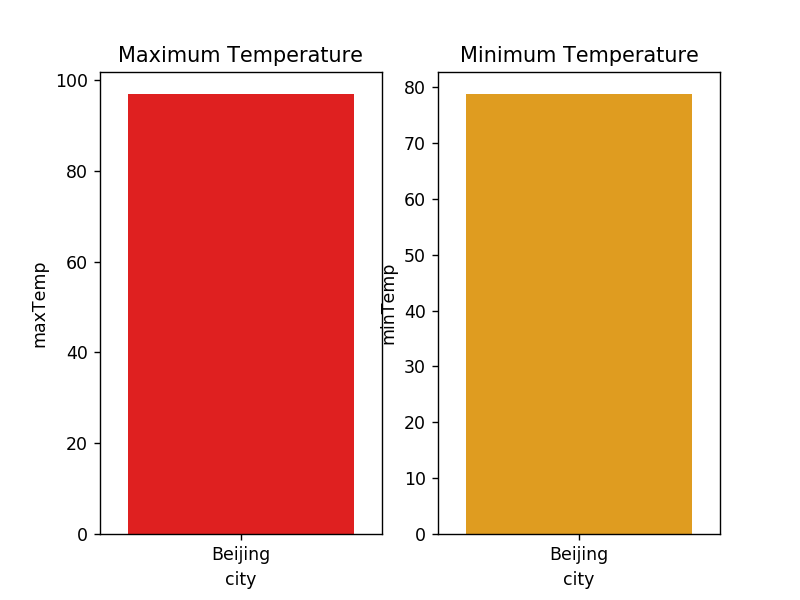

In [17]:
dates  = CanadaTemp.date.unique()
fig,ax = plt.subplots(1,2)

def animate(i):
    date = dates[i]
    currDateTemp = CanadaTemp[CanadaTemp["date"]==date]
    sns.barplot(ax=ax[0],y=currDateTemp["maxTemp"], x=currDateTemp["city"],data=currDateTemp,color="red")
    #title = ("Temperature Variation on: ", date)
    #print(title)
    #fig.suptitle(title)
    ax[0].set_title("Maximum Temperature")
    sns.barplot(ax=ax[1],y=currDateTemp["minTemp"], x=currDateTemp["city"],data=currDateTemp,color="orange")
    ax[1].set_title("Minimum Temperature")
    
ani = animation.FuncAnimation(fig,animate,frames=len(dates), repeat=True)
plt.show()

<IPython.core.display.Javascript object>


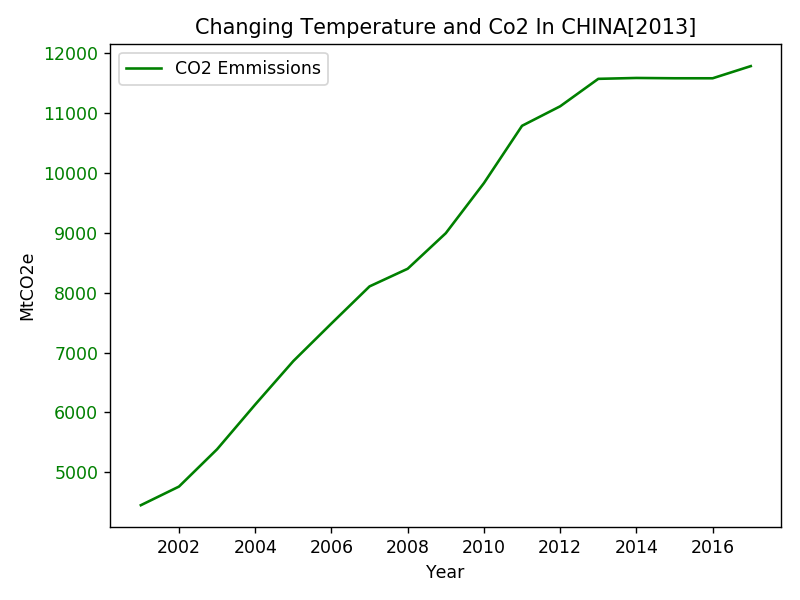

In [18]:
canada_temp_and_gas = gas_and_temp_national.loc[Country]

years = canada_temp_and_gas.index

fig, ax1 = plt.subplots()

ax1.set_xlabel("Year")
ax1.set_ylabel(unit_name)

ax1.plot(years, canada_temp_and_gas[unit_name], color="green", label="CO2 Emmissions", linestyle="-")
ax1.tick_params(axis='y', labelcolor="green")



plt.title("Changing Temperature and Co2 In "+ Country + str(policyYears))
plt.legend()
fig.tight_layout()
plt.show()

maxTemp    float64
minTemp    float64
prcp       float64
MtCO2e     float64
dtype: object


<IPython.core.display.Javascript object>


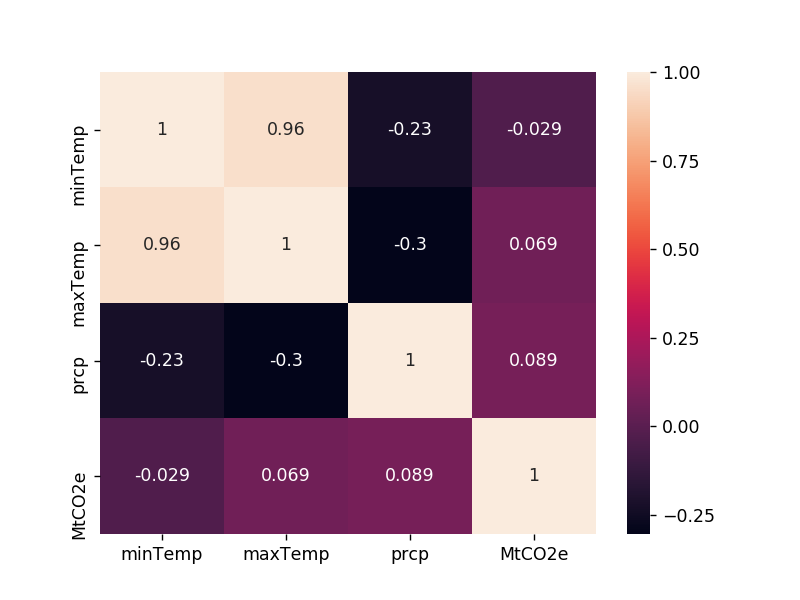

In [47]:
# basic correlation matrix
print(gas_and_temp_national.dtypes)
corr = gas_and_temp_national.loc[:,["minTemp", "maxTemp", "prcp", unit_name]].corr()
fig, ax1 = plt.subplots()
sns.heatmap(corr, annot=True)
plt.show()